# **California Gasoline Prices and Crude Oil Productions (PADD 5)**
<img src="https://upload.wikimedia.org/wikipedia/commons/3/3d/Shoulder_sleeve_insignia_of_the_10th_Mountain_Division_%281944-2015%29.svg" width="250px">

# **Notes**:
- Analysis on Crude Oil Consumptions / Comparison to other PADD Districts
- Analysis on Weekly Gasoline Prices in CA
- Modeling Weekly Average Gasoline Price in CA

In [1]:
import pandas as pd
import numpy as np 
import boto3 
import pymssql 
import pymysql
import json 
import warnings 
import re 
import os 
from selenium import webdriver

from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

import matplotlib.pyplot as plt 
import seaborn as sns 

from typing import List, Dict 
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 70
plt.style.use('ggplot')

## **ODIN MSSQL Backend** 

In [2]:
mssql_secrets: 'MSSQL' = boto3.client("secretsmanager")
user, passwd, host, db, = list(json.loads(mssql_secrets.get_secret_value(SecretId='mssql_db_analysis').get('SecretString')).values())
con: 'MSSQL' = pymssql.connect(user=user, password=passwd, database=db, host=host)
con.autocommit(True)

cust_func: 'DataFrame' = pd.read_sql("SELECT definition FROM sys.sql_modules", con=con) # T-SQL custom functions

## **ODIN MySQL Backend**

In [5]:
user1, passwd1, host1, db1, db_path = list(json.loads(mssql_secrets.get_secret_value(SecretId='mysql_develoment').get('SecretString')).values())
con1: 'MSSQL' = pymysql.connect(user=user1, password=passwd1, database=db1, host=host1)
con1.autocommit(True)

## **Crude Oils Productions by PADD District**

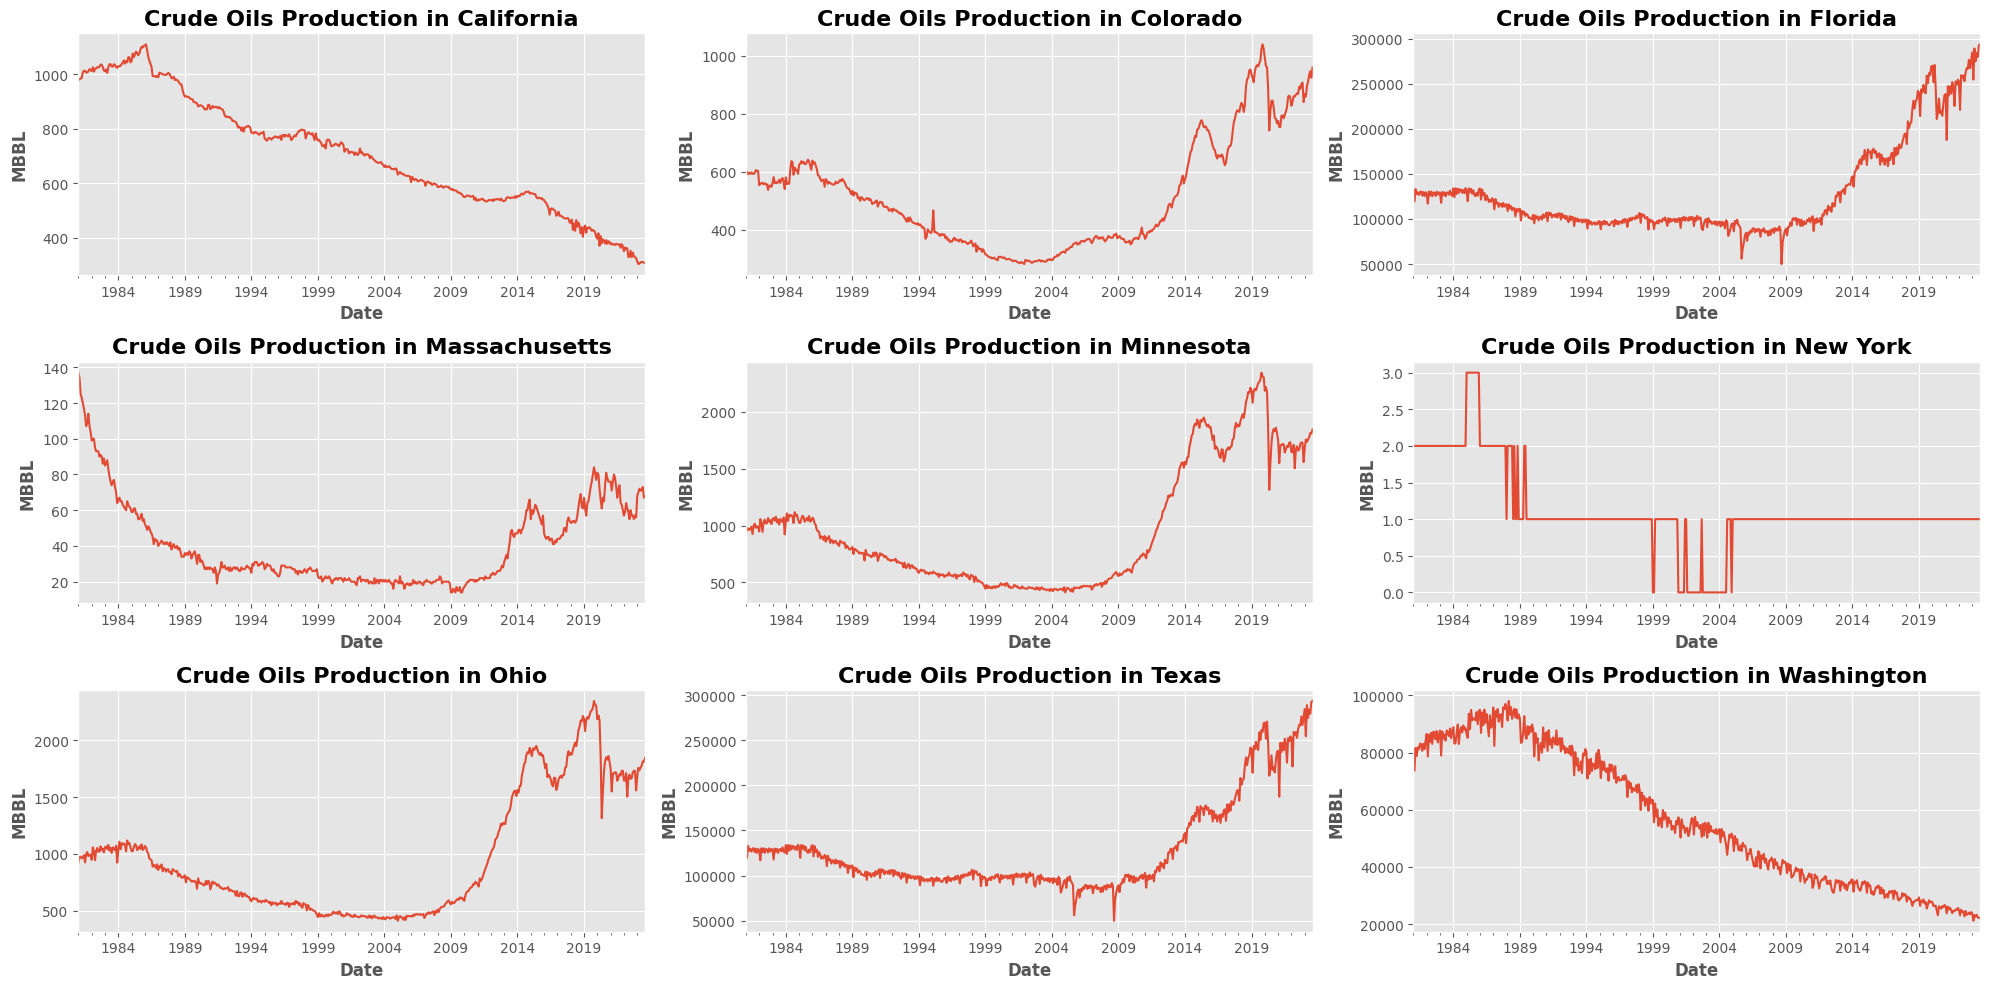

In [241]:
fig = plt.figure(figsize=(20,10)) 

for index,tbl in enumerate(list(pd.read_sql("SHOW TABLES LIKE '%prod%' " , con=con1).to_dict().values())[0].values(), 1): 
    ax = fig.add_subplot(3,3,index)
    current_df: 'DataFrame' = pd.read_sql(f"SELECT period, value FROM {tbl}", con=con1)
    current_df['period'] =  current_df['period'].apply(lambda row: pd.to_datetime("%s-01" % (row) ) )
    current_df.set_index('period')['value'].plot(ax=ax) 
    ax.set_title("Crude Oils Production in %s" % (tbl.split('_')[-1].title() if 'york' not in tbl.lower() else "%s" % ( ' '.join(tbl.split('_')[-2:]).title()  )  ), fontweight='bold', fontsize=16)
    ax.set_ylabel("MBBL", fontweight='bold')
    ax.set_xlabel("Date", fontweight='bold')

plt.tight_layout() 

## **Crude Oils Production in CA**

In [31]:
prod_ca: 'DataFrame' = pd.read_sql("SELECT * FROM productions_california", con=con1)
prod_ca['timestamp'] = pd.to_datetime(prod_ca['period'].apply(lambda row: '%s-01' % (row) ) )
prod_ca['month'] = prod_ca['timestamp'].apply(lambda row: row.month )
prod_ca['year'] = prod_ca['timestamp'].apply(lambda row: row.year )
prod_ca['month_name'] = prod_ca['timestamp'].apply(lambda row: row.month_name()  )
prod_ca.head()

,level_0,index,period,duoarea,area_name,product,product_name,process,process_name,series,series_description,value,units,timestamp,month,year,month_name
0,0,0,2023-08,SCA,CALIFORNIA,EPC0,Crude Oil,FPF,Field Production,MCRFPCA2,California Field Production of Crude Oil (Thou...,306,MBBL/D,2023-08-01,8,2023,August
1,1,1,2023-07,SCA,CALIFORNIA,EPC0,Crude Oil,FPF,Field Production,MCRFPCA2,California Field Production of Crude Oil (Thou...,308,MBBL/D,2023-07-01,7,2023,July
2,2,2,2023-06,SCA,CALIFORNIA,EPC0,Crude Oil,FPF,Field Production,MCRFPCA2,California Field Production of Crude Oil (Thou...,311,MBBL/D,2023-06-01,6,2023,June
3,3,3,2023-05,SCA,CALIFORNIA,EPC0,Crude Oil,FPF,Field Production,MCRFPCA2,California Field Production of Crude Oil (Thou...,310,MBBL/D,2023-05-01,5,2023,May
4,4,4,2023-04,SCA,CALIFORNIA,EPC0,Crude Oil,FPF,Field Production,MCRFPCA2,California Field Production of Crude Oil (Thou...,310,MBBL/D,2023-04-01,4,2023,April


## **Crude Oils Production in `California` by `Month` and `Year`**

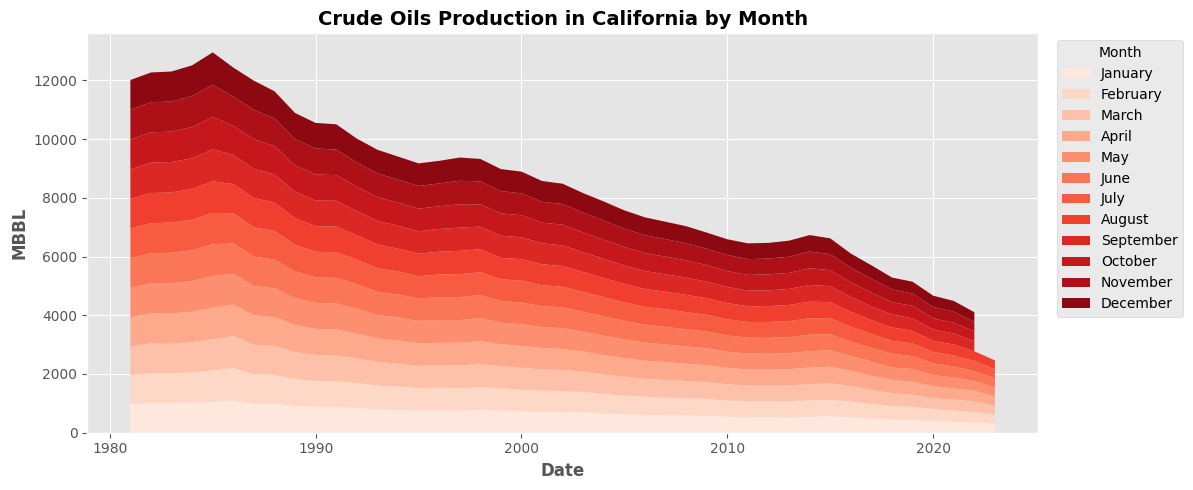

In [43]:
prod_summary: 'DataFrame' = pd.pivot_table(data=prod_ca, index='year', columns='month', values='value', aggfunc='mean' ).rename(dict(prod_ca[['month','month_name']].drop_duplicates().sort_values(by='month').apply(lambda row: (row['month'], row['month_name'] ), axis=1).tolist()),axis=1)
fig = plt.figure(figsize=(12,5)) 
ax = fig.add_subplot()
ax.stackplot(prod_summary.index.tolist(), 
             prod_summary['January'].tolist(),
             prod_summary['February'].tolist(),
             prod_summary['March'].tolist(),
             prod_summary['April'].tolist(),
             prod_summary['May'].tolist(),
             prod_summary['June'].tolist(),
             prod_summary['July'].tolist(),
             prod_summary['August'].tolist(),
             prod_summary['September'].tolist(),
             prod_summary['October'].tolist(),
             prod_summary['November'].tolist(),
             prod_summary['December'].tolist(),
             labels=prod_summary.columns.tolist(),
             colors=sns.color_palette(palette='Reds', n_colors=12).as_hex()
             )

ax.set_title("Crude Oils Production in California by Month", fontweight='bold', fontsize=14)
ax.set_ylabel("MBBL", fontweight='bold')
ax.set_xlabel("Date", fontweight='bold')
ax.legend(title="Month", bbox_to_anchor=(1.16,1))
plt.tight_layout()

## **United States Historical Gasoline Fund, LP (UGA) (`Yahoo Finance`)**

In [23]:
uga_df: 'DataFrame' = pd.read_csv(os.path.join( os.path.join( db_path, 'dataset'), 'UGA.csv' ) )
uga_df['Date'] = pd.to_datetime(uga_df['Date'])
uga_df.set_index('Date').sort_index().head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-03-07,49.340000,50.250000,49.049999,50.230000,50.230000,21200
2008-03-10,49.509998,50.740002,49.189999,50.610001,50.610001,35100
2008-03-11,50.689999,50.790001,49.779999,50.700001,50.700001,27700
2008-03-12,50.700001,50.930000,49.900002,50.919998,50.919998,28600
2008-03-13,50.360001,50.700001,49.180000,49.939999,49.939999,43300


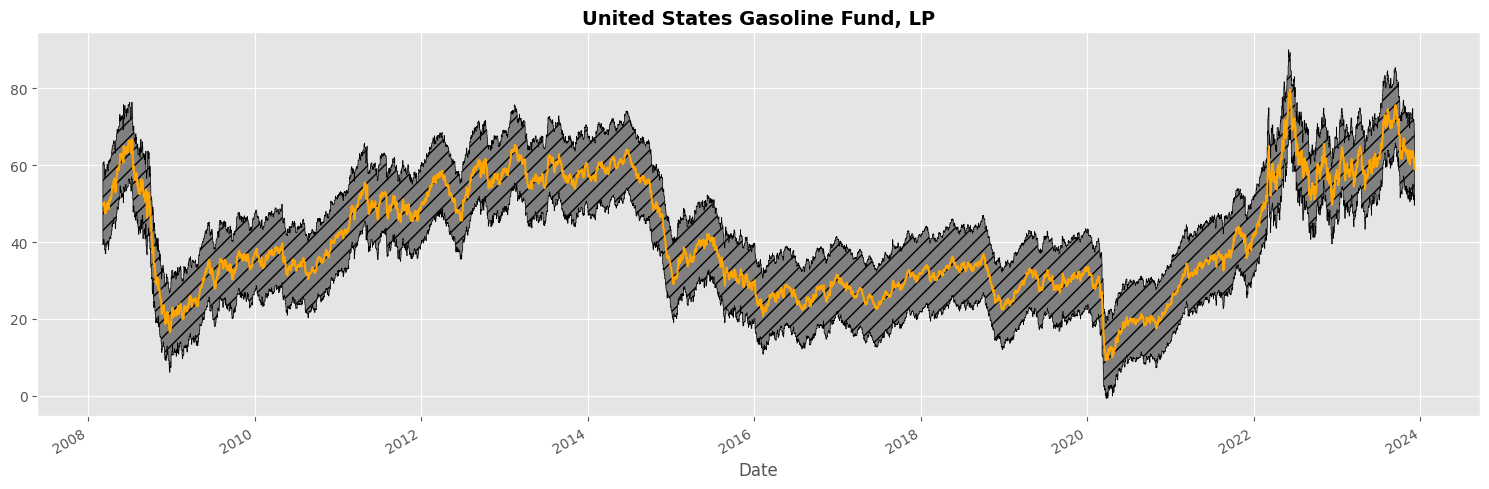

In [46]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot()
uga_df.set_index('Date').apply(lambda row: (row['Low'] + row['High']) / 2 ,axis=1).plot(ax=ax,color='orange')
ax.fill_between(x=uga_df['Date'].tolist(), y1=uga_df['Open'] - 10, y2=uga_df['Close'] + 10 , color='grey', step='pre', hatch='//', edgecolor='black')
ax.set_title("United States Gasoline Fund, LP", fontweight='bold', fontsize=14)

plt.tight_layout() 

## **Weekly Pricing in CA by `EIA.gov`**

In [5]:
pricing_ca: 'DataFrame' = pd.read_sql("SELECT * FROM pricing_california", con=con1)
pricing_ca.drop(['level_0'], inplace=True, axis=1)
pricing_ca['period'] = pd.to_datetime(pricing_ca['period'])
pricing_ca['month'] = pricing_ca['period'].apply(lambda row: row.month) 
pricing_ca['month_name'] = pricing_ca['period'].apply(lambda row: row.month_name() ) 
pricing_ca['year'] = pricing_ca['period'].apply(lambda row: row.year) 
months_lookup: Dict = dict(pricing_ca[['month_name', 'month']].drop_duplicates().sort_values(by='month').apply(lambda row: (row.month_name, row.month) , axis=1 ).tolist())

pricing_ca.head()

,index,period,duoarea,area_name,product,product_name,process,process_name,series,series_description,value,units,month,month_name,year
0,0,2023-11-20,R50,PADD 5,EPMRU,Conventional Regular Gasoline,PTE,Retail Sales,EMM_EPMRU_PTE_R50_DPG,West Coast Regular Conventional Retail Gasolin...,4.144,$/GAL,11,November,2023
1,1,2023-11-13,R50,PADD 5,EPMRU,Conventional Regular Gasoline,PTE,Retail Sales,EMM_EPMRU_PTE_R50_DPG,West Coast Regular Conventional Retail Gasolin...,4.238,$/GAL,11,November,2023
2,2,2023-11-06,R50,PADD 5,EPMRU,Conventional Regular Gasoline,PTE,Retail Sales,EMM_EPMRU_PTE_R50_DPG,West Coast Regular Conventional Retail Gasolin...,4.309,$/GAL,11,November,2023
3,3,2023-10-30,R50,PADD 5,EPMRU,Conventional Regular Gasoline,PTE,Retail Sales,EMM_EPMRU_PTE_R50_DPG,West Coast Regular Conventional Retail Gasolin...,4.415,$/GAL,10,October,2023
4,4,2023-10-23,R50,PADD 5,EPMRU,Conventional Regular Gasoline,PTE,Retail Sales,EMM_EPMRU_PTE_R50_DPG,West Coast Regular Conventional Retail Gasolin...,4.515,$/GAL,10,October,2023


## **Histogram Gasoline Price in CA** 

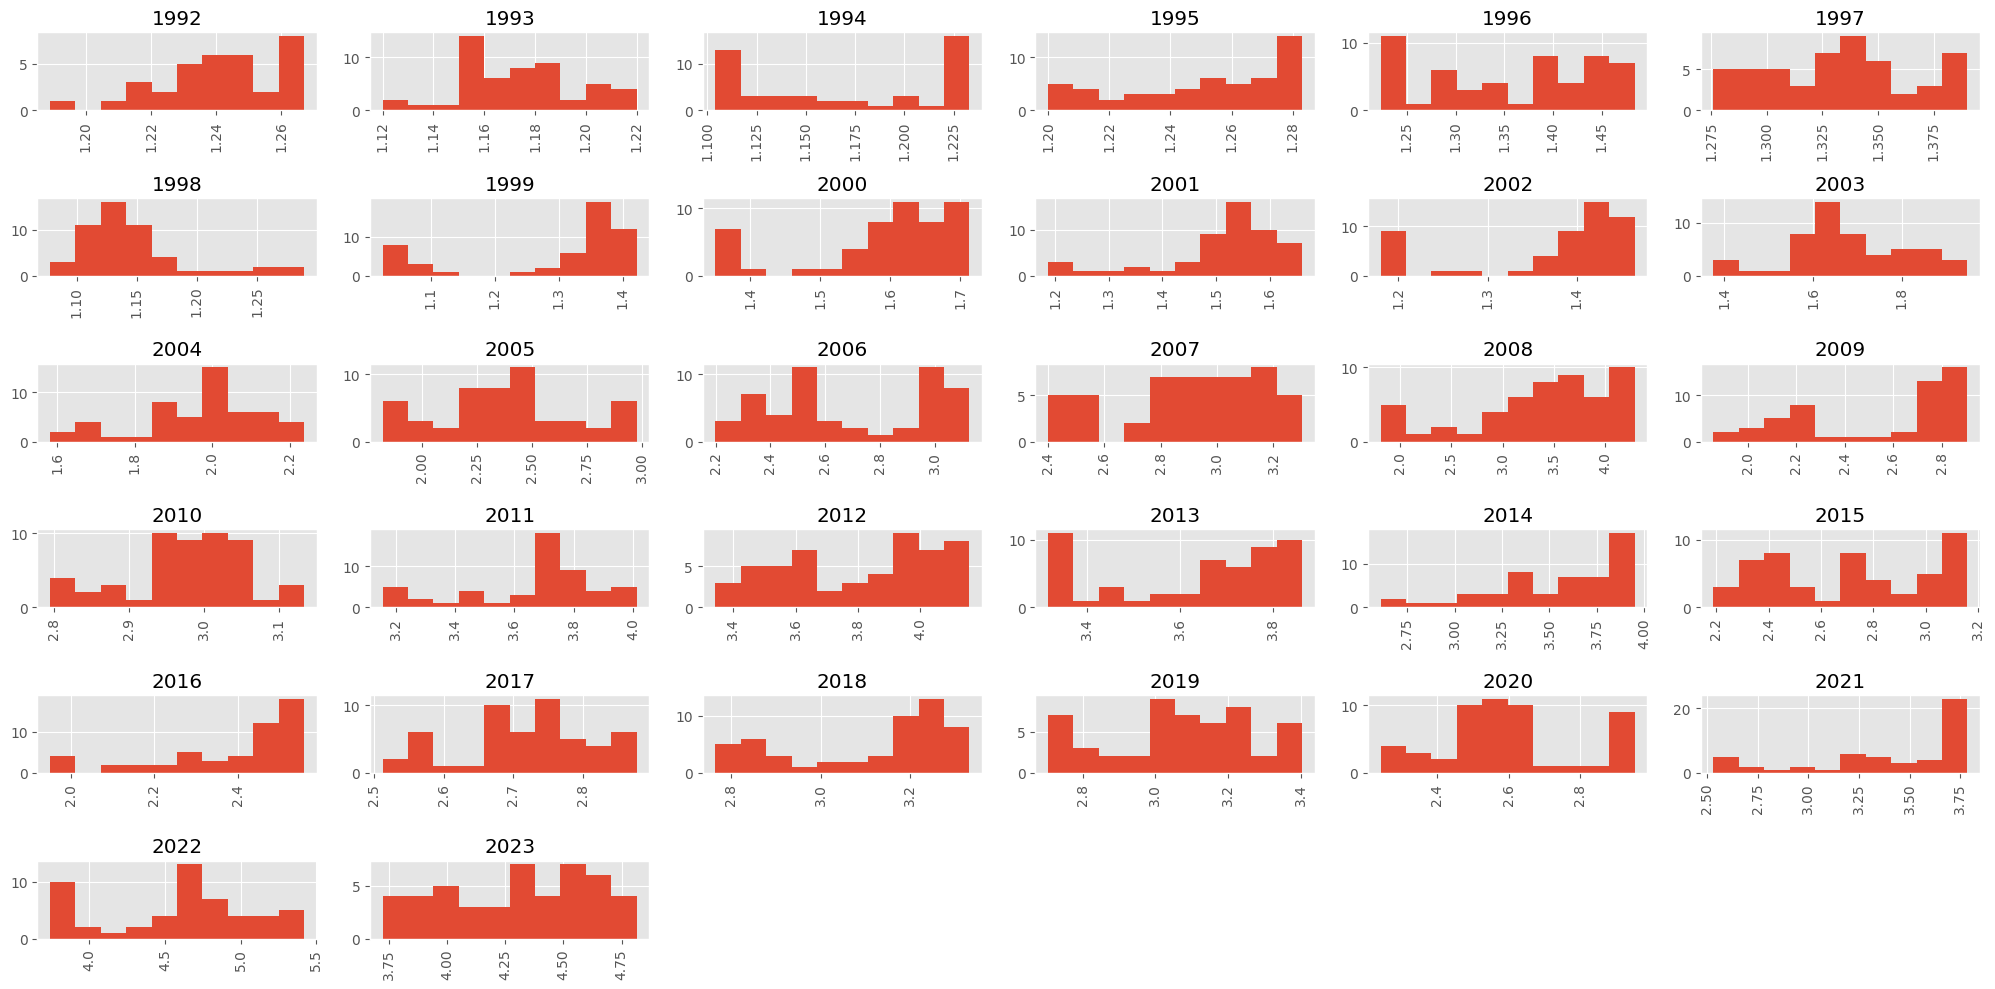

In [46]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()
axs = pricing_ca.hist(by='year', column='value', ax=ax)

plt.tight_layout() 

## **Weekly Gasoline Pricing in CA**

Note: Gasoline Price Fluctuations every $\pm$ `5 Years`

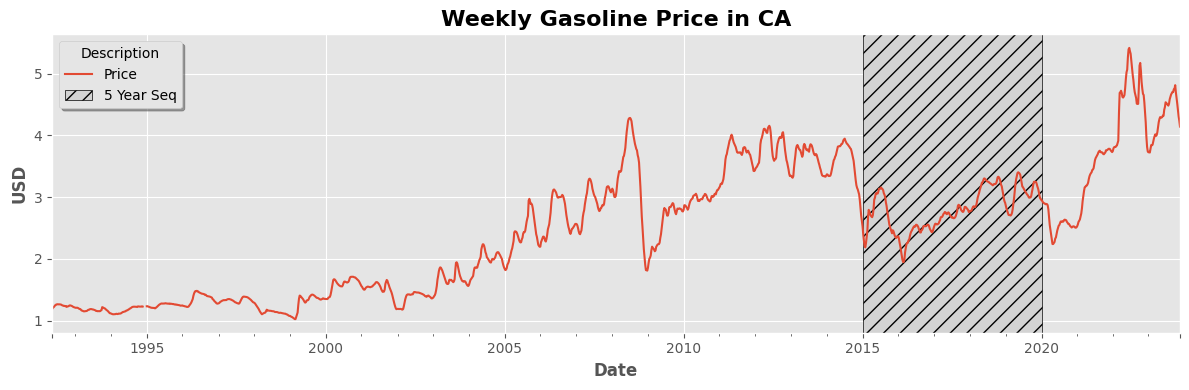

In [8]:
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot()
pricing_ca.set_index('period').rename({'value': 'Price'}, axis=1)['Price'].plot(ax=ax)
ax.axvspan(xmin=pd.to_datetime("2015-01-01"), xmax=pd.to_datetime("2020-01-01"), hatch='//', facecolor='lightgray', edgecolor='black', label='5 Year Seq' )
ax.set_title( "Weekly Gasoline Price in CA", fontweight='bold', fontsize=16)
ax.set_ylabel("USD", fontweight='bold')
ax.set_xlabel('Date', fontweight='bold')
ax.legend(title="Description", fancybox=True, shadow=True) # cyclical pattern (+- 5 years) 
plt.tight_layout()

## **Gasoline Pricing in CA (2015 -2020)**

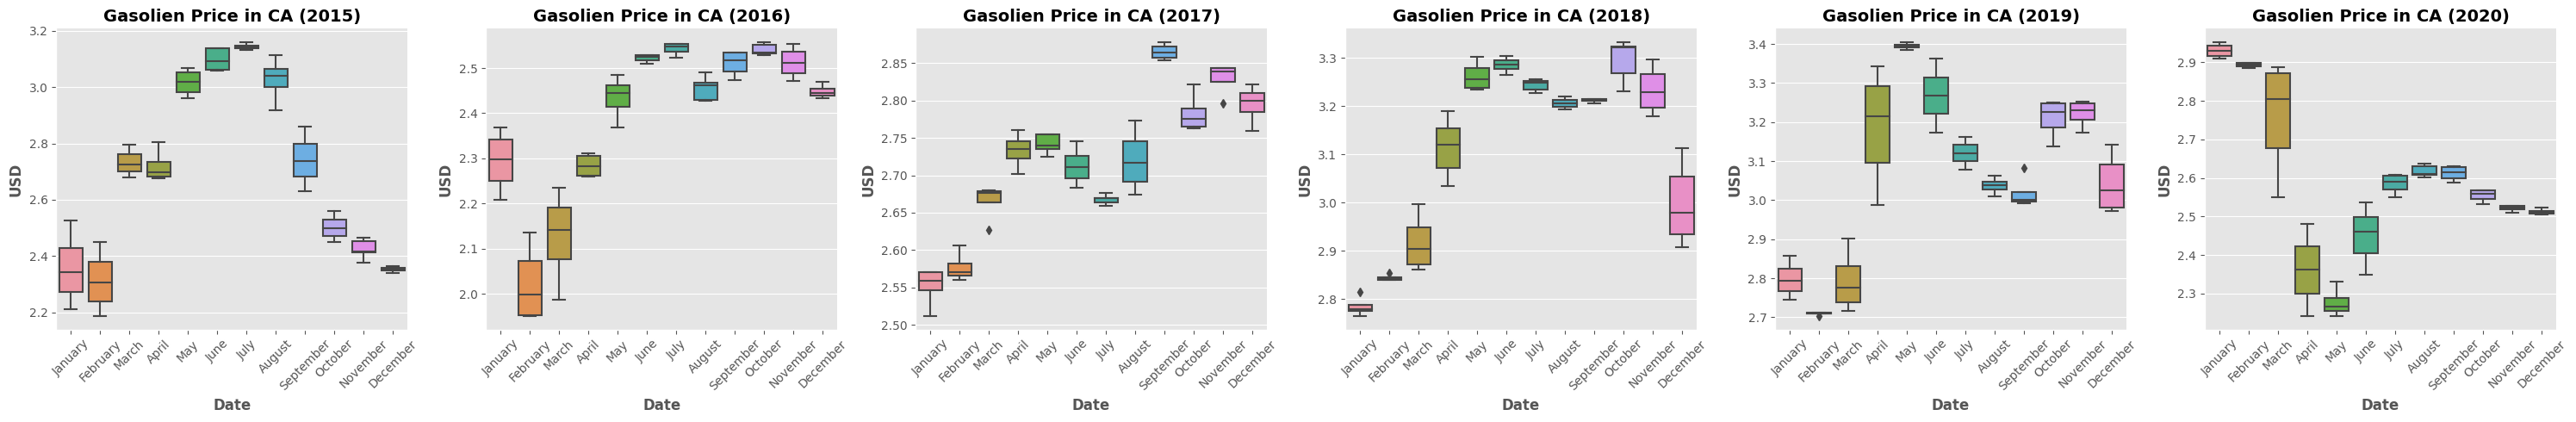

In [47]:
axs = sns.catplot(data=pricing_ca.query('year >= 2015 and year <= 2020'), col='year', x='month', y='value', kind='box', sharey=False) 
for ax in axs.axes.ravel(): 
    ax.set_title("Gasolien Price in CA (%s)" % ( re.sub("year = ", "" , ax.get_title() ) ) , fontweight='bold', fontsize=14)
    ax.set_xticklabels(list(months_lookup.keys()), rotation=45)
    ax.set_ylabel("USD", fontweight='bold' )
    ax.set_xlabel("Date", fontweight='bold')
plt.tight_layout() 

## **Gasoline Pricing in CA (2020 -2023)**

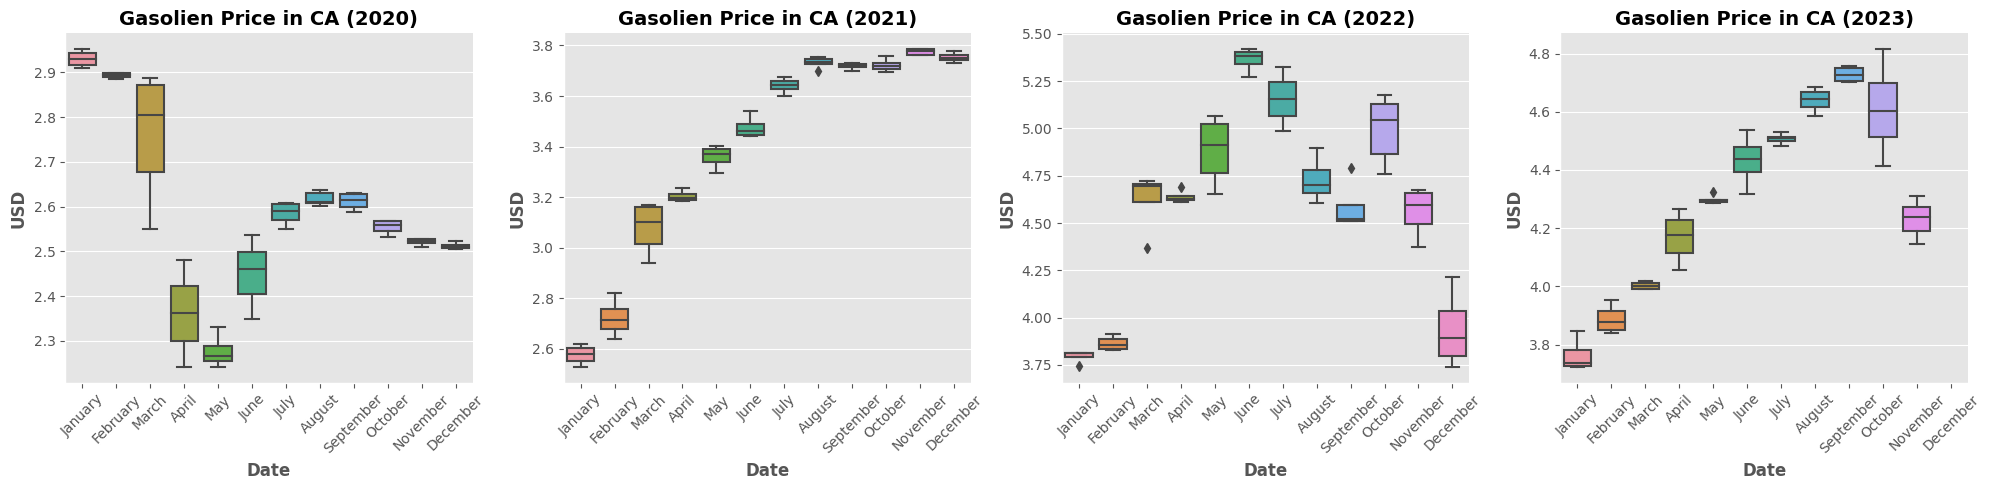

In [46]:
axs = sns.catplot(data=pricing_ca.query('year >= 2020 and year <= 2023'), col='year', x='month', y='value', kind='box', sharey=False) 
for ax in axs.axes.ravel(): 
    ax.set_title("Gasolien Price in CA (%s)" % ( re.sub("year = ", "" , ax.get_title() ) ), fontweight='bold', fontsize=14)
    ax.set_xticklabels(list(months_lookup.keys()), rotation=45)
    ax.set_ylabel("USD", fontweight='bold' )
    ax.set_xlabel("Date", fontweight='bold')
plt.tight_layout() 

## **Season-Trend Decomposition Gasoline Pricing in CA**

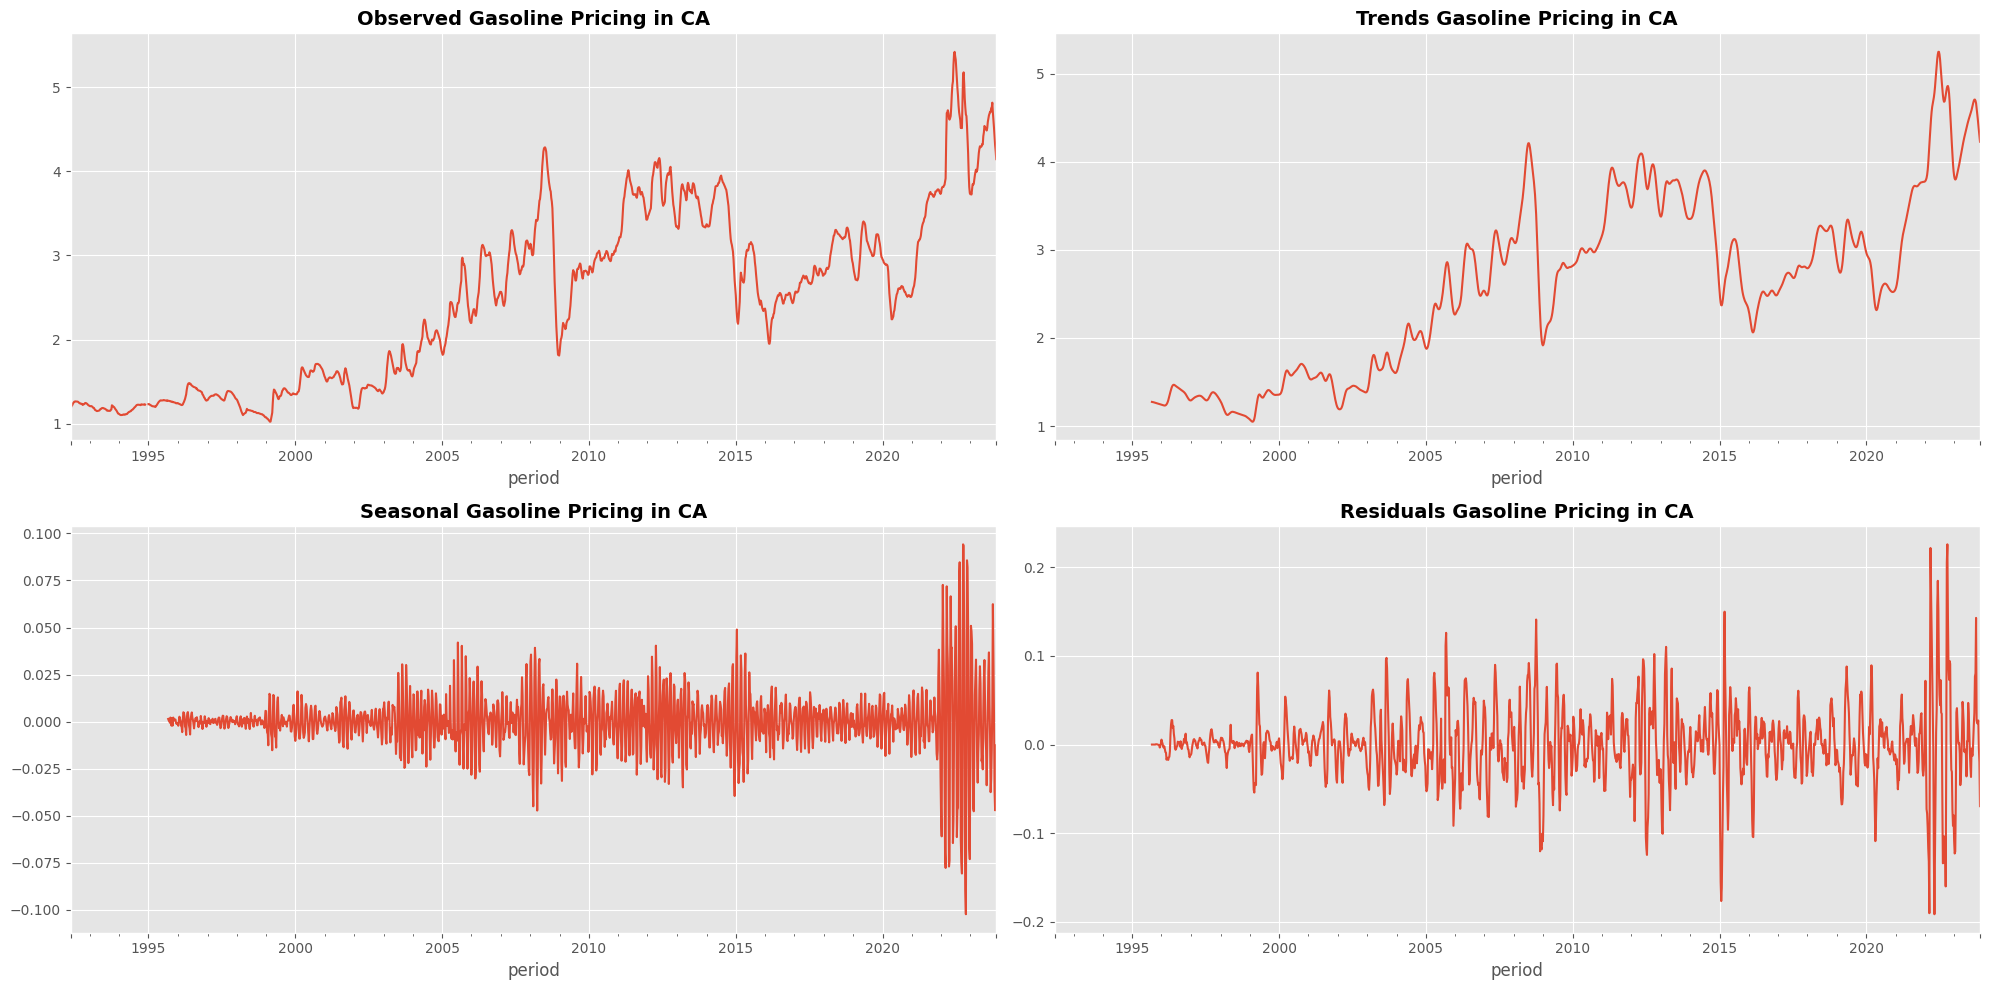

In [45]:
pricing_STL: 'STL' = STL(pricing_ca.set_index('period')['value'] ,period=7).fit() 
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2,2,1) 
pricing_STL.observed.plot(ax=ax) 
ax.set_title("Observed Gasoline Pricing in CA", fontweight='bold', fontsize=14)

ax = fig.add_subplot(2,2,2)
pricing_STL.trend.plot(ax=ax) 
ax.set_title("Trends Gasoline Pricing in CA", fontweight='bold', fontsize=14)

ax = fig.add_subplot(2,2,3)
pricing_STL.seasonal.plot(ax=ax) 
ax.set_title("Seasonal Gasoline Pricing in CA", fontweight='bold', fontsize=14)

ax = fig.add_subplot(2,2,4)
pricing_STL.resid.plot(ax=ax) 
ax.set_title("Residuals Gasoline Pricing in CA", fontweight='bold', fontsize=14)

plt.tight_layout()

## **Distribution and Monthly Gasoline Pricing in CA**

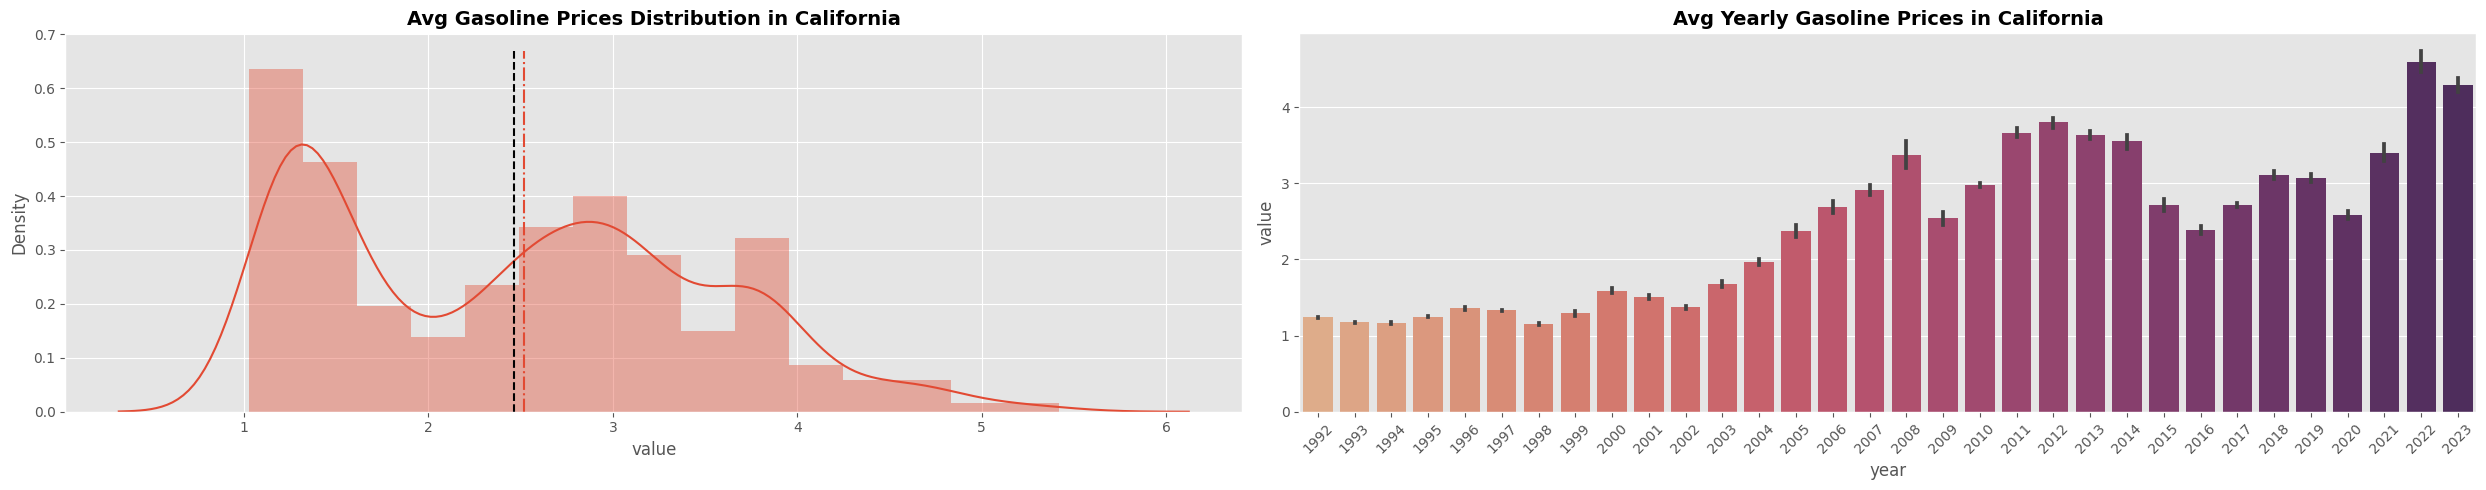

In [13]:
fig = plt.figure(figsize=(25,5)) 
ax = fig.add_subplot(1,2,1)

pricing: 'Series' = pricing_ca['value']
sns.distplot(pricing, ax=ax)
ymin,ymax = ax.get_ylim()
mean: float = pricing.mean()
median: float = pricing.median()
ax.vlines(mean, ymin=ymin, ymax=ymax, linestyle='--', label=f"Mean: {mean:.2f}", color='black' ) 
ax.vlines(median, ymin=ymin, ymax=ymax, linestyle='-.', label=f"Median: {mean:.2f}" ) 
ax.set_title("Avg Gasoline Prices Distribution in California", fontweight='bold', fontsize=14)

ax = fig.add_subplot(1,2,2)
sns.barplot(data=pricing_ca, x='year', y='value' , palette='flare', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Avg Yearly Gasoline Prices in California", fontweight='bold', fontsize=14)

plt.tight_layout()

## **Mean and Variance Avg Weekly Gasoline Pricing in CA** 

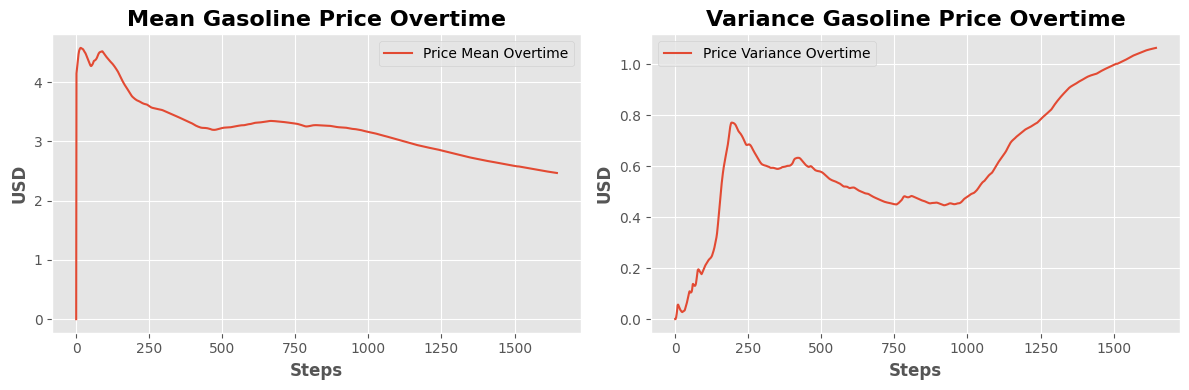

In [79]:
mean_pricing: List = []
var_pricing: List = []
for index in range(pricing_ca.shape[0]):
    mean_pricing.append( pricing_ca['value'].iloc[:index].mean() )
    var_pricing.append(pricing_ca['value'].iloc[:index].var() ) 
    
fig = plt.figure(figsize=(12,4)) 
ax = fig.add_subplot(1,2,1) 
pd.DataFrame({'Price Mean Overtime': mean_pricing }).replace({np.nan:0.0}).plot(ax=ax)
ax.set_title("Mean Gasoline Price Overtime", fontweight='bold', fontsize=16)
ax.set_xlabel("Steps", fontweight='bold')
ax.set_ylabel("USD", fontweight='bold')

ax = fig.add_subplot(1,2,2) 
pd.DataFrame({'Price Variance Overtime': var_pricing }).replace({np.nan:0.0}).plot(ax=ax)
ax.set_title("Variance Gasoline Price Overtime", fontweight='bold', fontsize=16)
ax.set_xlabel("Steps", fontweight='bold')
ax.set_ylabel("USD", fontweight='bold')

plt.tight_layout() 

## **Adfuller Test**
**Note**: Testing for stationarity, after 1 differencing p-value < `0.05`

In [86]:
adf1: 'Adfuller' = adfuller( pricing_ca.set_index('period')['value'].replace({np.nan:0.0}) )
pd.DataFrame({'ADF':adf1[0], 'p-value': adf1[1]}, index=['Adfuller Test 1']).transpose()

,Adfuller Test 1
ADF,-1.881518
p-value,0.340805


In [103]:
adf2: 'Adfuller' = adfuller( np.diff(pricing_ca.set_index('period')['value'].replace({np.nan:0.0}) , n=1) )
pd.DataFrame({'ADF':adf2[0], 'p-value': adf2[1]}, index=['Adfuller Test 2']).transpose()

,Adfuller Test 2
ADF,-9.897356e+00
p-value,3.429725e-17


## **Mean and Variance of the Gasoline Price Overtime After Applying Differencing (`d:1`)**

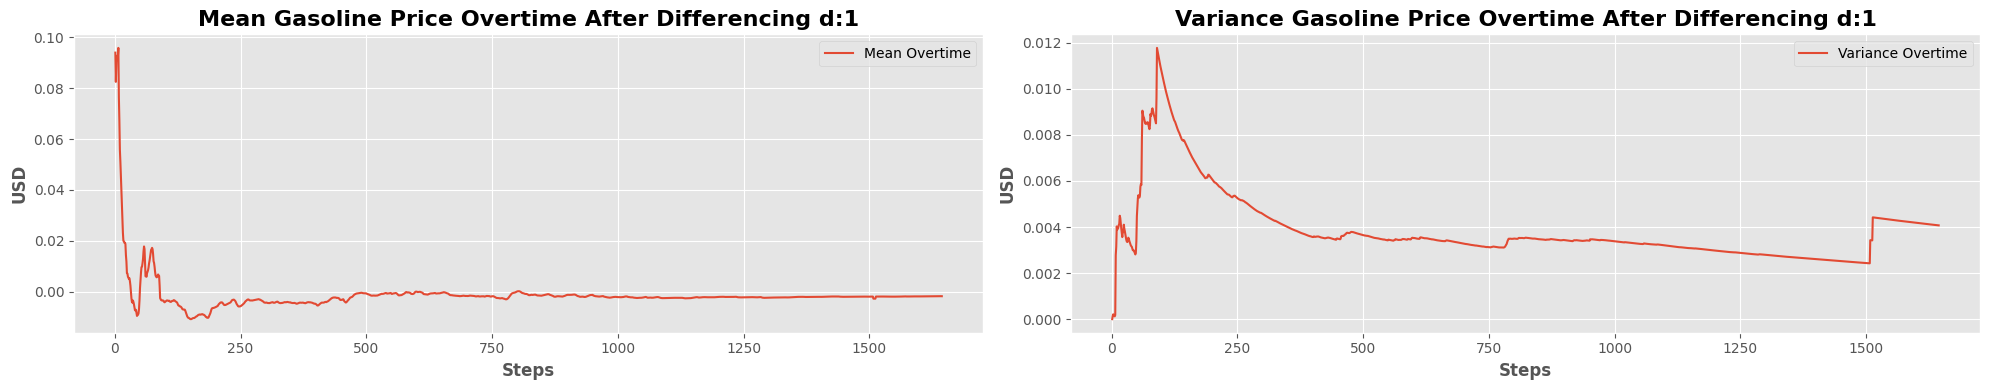

In [102]:
diff_one: 'np.array' = np.diff(pricing_ca.set_index('period')['value'].replace({np.nan:0.0}) , n=1)
fig = plt.figure(figsize=(20,4) ) 
ax = fig.add_subplot(1,2,1) 
ax.plot( range(len(diff_one)) ,  [ diff_one[:index].mean() for index in range(len(diff_one)) ], label="Mean Overtime" )
ax.set_title("Mean Gasoline Price Overtime After Differencing d:1", fontweight='bold', fontsize=16)
ax.set_xlabel("Steps" , fontweight='bold')
ax.set_ylabel("USD", fontweight='bold')
ax.legend() 

ax = fig.add_subplot(1,2,2) 
ax.plot( range(len(diff_one)) ,  [ diff_one[:index].var() for index in range(len(diff_one)) ], label="Variance Overtime" )
ax.set_title("Variance Gasoline Price Overtime After Differencing d:1", fontweight='bold', fontsize=16)
ax.set_xlabel("Steps" , fontweight='bold')
ax.set_ylabel("USD", fontweight='bold')

ax.legend() 
plt.tight_layout() 

## **Autocorrelations and Partical Auto Correlations of the Weekly Gasoline Pricing in CA**

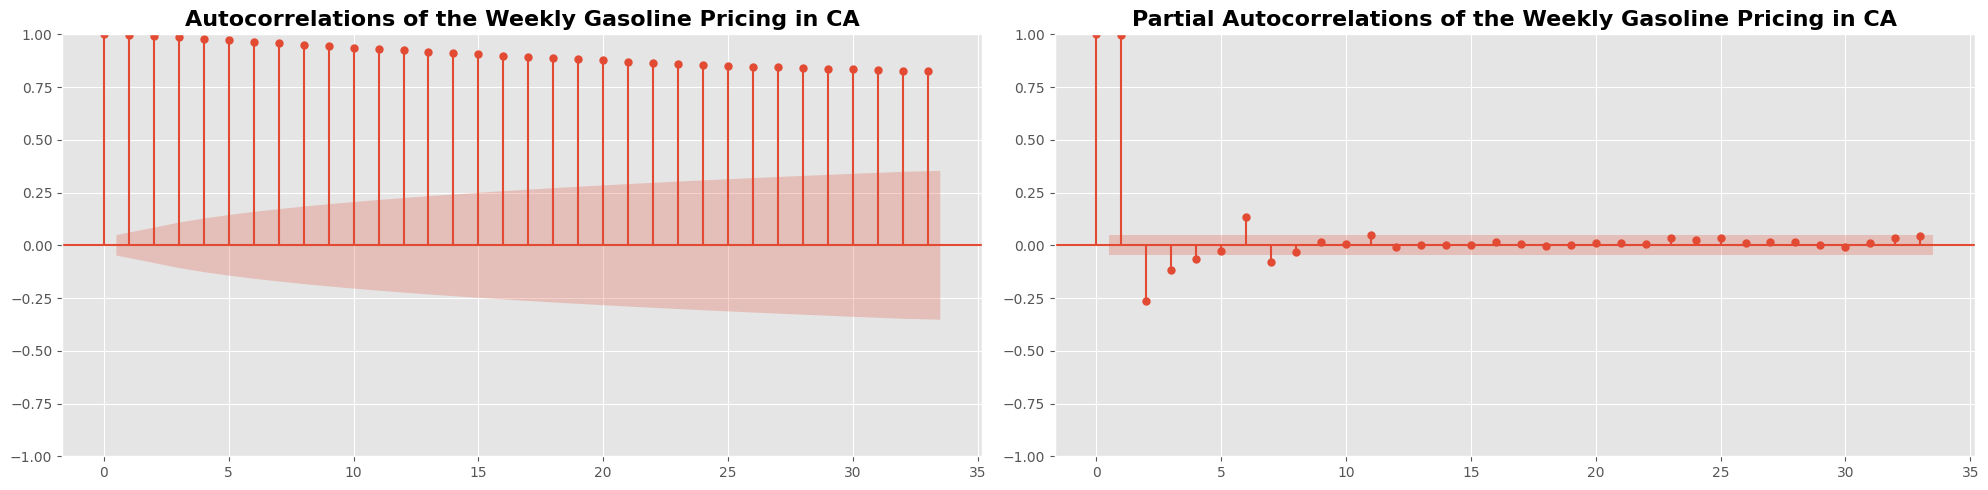

In [110]:
fig = plt.figure(figsize=(20, 5)) 
ax = fig.add_subplot(1,2,1)
plot_acf(pricing_ca.set_index('period')['value'].replace({np.nan:0.0}), ax=ax) 
ax.set_title("Autocorrelations of the Weekly Gasoline Pricing in CA", fontweight='bold', fontsize=16)

ax = fig.add_subplot(1,2,2)
plot_pacf(pricing_ca.set_index('period')['value'].replace({np.nan:0.0}), ax=ax) 
ax.set_title("Partial Autocorrelations of the Weekly Gasoline Pricing in CA", fontweight='bold', fontsize=16)

plt.tight_layout()

## **Finished Motor Gasoline Consumptions**

In [60]:
consumption_df: 'DataFrame' = pd.read_sql("""SELECT 
                                                c.period AS `timestamp`, 
                                                c.product_name, 
                                                c.value, 
                                                c.units
                                                
                                             FROM consumption_sales_united_states c 
                                          """
                                          , con=con1)
consumption_df.head()

,timestamp,product_name,value,units
0,2023-11-17,Finished Motor Gasoline,8480,MBBL/D
1,2023-11-10,Finished Motor Gasoline,8949,MBBL/D
2,2023-11-03,Finished Motor Gasoline,9492,MBBL/D
3,2023-10-27,Finished Motor Gasoline,8697,MBBL/D
4,2023-10-20,Finished Motor Gasoline,8864,MBBL/D


## **Actual Gasoline Prices in `California`**
- **Note**: Collected from various Gas Stations in `CA` state

In [33]:
query: str = """ 

WITH table_names AS (
    SELECT TOP 13 id,
           name 
    FROM sysobjects WHERE name NOT LIKE '%GET%' AND name NOT LIKE '%PK%' AND name NOT LIKE '%FK%'  AND name NOT LIKE '%DF%' ORDER BY crdate DESC
    )

SELECT 
    s2.name AS "table_name", 
    s.name AS "column_name"
    
FROM syscolumns s
JOIN table_names AS s2 ON s2.id = s.id
WHERE s2.name LIKE '%Price%' OR s2.name LIKE '%station%' OR s2.name LIKE '%Store%' 

"""
tbl_lookup: 'DataFrame' = pd.read_sql(query, con=con )

tbl1, tbl2, tbl3, tbl4 = (tbl_lookup['table_name'].unique().tolist()[:2] + tbl_lookup['table_name'].unique().tolist()[-2:])[-1::-1]
query: str = f"""
(SELECT 
    g.name,
    g.price_unit, 
    g.region, 
    g.state,
    g.pay_status,
    g.enterprise,
    sl.address,
    sl.latitude,
    sl.longitude, 
    sl.ratings_count, 
    sl.star_rating,
    sl.zip_code,
    sl.country,
    cp.posted_time AS "timestamp",
    cp.price

FROM {tbl1} g 
JOIN {tbl2} sl ON sl.gasstation_id = g.gasstation_id
JOIN {tbl3} cp ON cp.store_id = sl.store_id
WHERE sl.region = 'CA')

UNION ALL 
(SELECT 
    g.name,
    g.price_unit, 
    g.region, 
    g.state,
    g.pay_status,
    g.enterprise,
    sl.address,
    sl.latitude,
    sl.longitude, 
    sl.ratings_count, 
    sl.star_rating,
    sl.zip_code,
    sl.country,
    cp.posted_time AS "timestamp",
    cp.price

FROM {tbl1} g 
JOIN {tbl2} sl ON sl.gasstation_id = g.gasstation_id
JOIN {tbl4} cp ON cp.store_id = sl.store_id
WHERE sl.region = 'CA')

"""


ca_pricing: 'DataFrame' = pd.read_sql(query, con=con) 
ca_pricing['month'] = ca_pricing['timestamp'].apply(lambda row: row.month) 
ca_pricing['year'] = ca_pricing['timestamp'].apply(lambda row: row.year) 
ca_pricing['month_name'] = ca_pricing['timestamp'].apply(lambda row: row.month_name()) 
ca_pricing['transc_date'] = ca_pricing['timestamp'].apply(lambda row: pd.to_datetime( '%s-%s-%s' % (row.year, row.month, row.day) ) )
ca_pricing = ca_pricing.drop_duplicates(['timestamp', 'address', 'latitude','longitude'])

In [8]:
ca_pricing.head()

,name,price_unit,region,state,pay_status,enterprise,address,latitude,longitude,ratings_count,star_rating,zip_code,country,timestamp,price,month,year,month_name,transc_date
0,Shell,dollars_per_gallon,Sterling,Alaska,0,0,2110 Eureka Way,40.586932,-122.402093,30,4,96001,US,2023-08-11 17:41:21.030,3.99,8,2023,August,2023-08-11
1,Mono Winds Casino Fuel,dollars_per_gallon,Auberry,California,1,0,37302 Rancheria Ln,37.083564,-119.464517,45,4,93602,US,2023-08-12 00:49:48.357,4.22,8,2023,August,2023-08-12
2,Yokut Gas Station,dollars_per_gallon,Lemoore,California,1,1,17051 Jersey Ave,36.239609,-119.763358,558,4,93245,US,2023-08-12 01:05:38.797,4.29,8,2023,August,2023-08-12
3,Red Earth Casino,dollars_per_gallon,Salton Sea Beach,California,1,0,3089 Norm Niver Rd,33.352776,-116.01911,167,4,92275-6550,US,2023-08-11 22:19:07.877,4.29,8,2023,August,2023-08-11
4,Shell,dollars_per_gallon,Sterling,Alaska,0,0,7741 Auburn Blvd,38.70709689231,-121.290677458044,106,3,95610-2125,US,2023-08-11 10:41:22.977,4.44,8,2023,August,2023-08-11


## **Weekly Avg Gasoline Price in CA According to GasBuddy (Left and) EIA (Right)** 

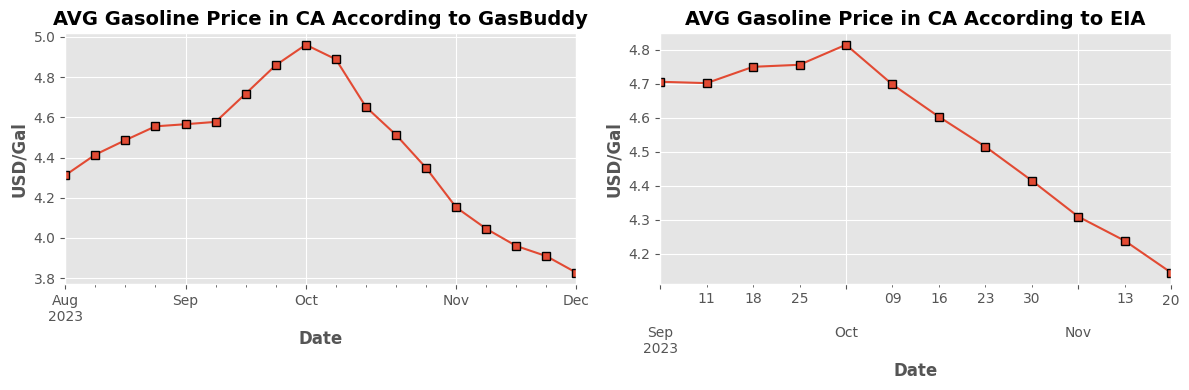

In [177]:
fig = plt.figure(figsize=(12,4) ) 
ax = fig.add_subplot(1,2,1)
ca_pricing.groupby("transc_date")['price'].mean().resample('W').mean().plot(ax=ax, marker='s', mec='black') 
ax.set_xlabel("Date", fontweight='bold')
ax.set_ylabel("USD/Gal", fontweight='bold')
ax.set_title("AVG Gasoline Price in CA According to GasBuddy", fontweight='bold', fontsize=14)

ax = fig.add_subplot(1,2,2)
pricing_ca.query("year >= 2023 and ( month > 8 and month < 12 )").set_index('period')['value'].plot(ax=ax, marker='s', mec='black') 
ax.set_xlabel("Date", fontweight='bold')
ax.set_ylabel("USD/Gal", fontweight='bold')
ax.set_title("AVG Gasoline Price in CA According to EIA", fontweight='bold', fontsize=14)

plt.tight_layout() 